# Imports

In [ ]:

# ¡¡¡ Conectar con Google Drive !!!

# Se instala e importa import_ipynb para poder acceder a clases/funciones de otros notebooks
!pip install import-ipynb

# Se cambia al directorio donde esté el notebook con las clases a importar
%cd "/content/drive/MyDrive/Colab_Notebooks"

!pip install --upgrade --force-reinstall --no-deps albumentations
!pip install segmentation_models_pytorch

/content/drive/MyDrive/Colab_Notebooks
  Using cached albumentations-1.0.3-py3-none-any.whl (98 kB)
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.0.3
    Uninstalling albumentations-1.0.3:
      Successfully uninstalled albumentations-1.0.3


In [ ]:
import numpy as np
import pandas as pd
import os , glob
import matplotlib.pyplot as plt
from PIL import Image
import imageio
import cv2
from tqdm import tqdm
import torch.nn as nn

import torch
from torch import Tensor
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from keras.preprocessing import image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split


from torch.utils.data import Dataset , DataLoader
from torchvision import transforms , utils , datasets

import import_ipynb
from models import UNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

importing Jupyter notebook from models.ipynb


# Rutas y dataframe

In [ ]:
img_fol= '/content/drive/MyDrive/Colab_Notebooks/carvana/train/' # Carpeta que contiene las imágenes

# División en entrenamiento y validación
df = pd.DataFrame(os.listdir(img_fol), columns = ['name'])       # Se estructura de forma tabular el contenido de la carpeta 'img_fol'
df = df.iloc[:2000]    # Se reduce el dataframe a 1000 imagenes
df_train, df_val = train_test_split(df, test_size=.2, random_state=42, shuffle=True, stratify=None) 

# Tras realizar la división, es necesario reiniciar los índices
df_train = df_train.reset_index()
df_val = df_val.reset_index()

print(f"Total: {len(df)} -- Entrenamiento: {len(df_train)} -- Validación: {len(df_val)}")



Total: 2000 -- Entrenamiento: 1600 -- Validación: 400


# DataSet y DataLoader

In [ ]:
class CarDataset(Dataset):
    def __init__(self, df):
        # self.df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/carvana/train_masks.csv')
        self.img_transform = A.Compose([
            A.Resize(256, 256),
            A.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
        self.mask_transform = A.Compose([
            A.Resize(256, 256),
            ToTensorV2()
        ])
        self.df = df 
        self.img_fol= '/content/drive/MyDrive/Colab_Notebooks/carvana/train/'
        self.mask_fol = '/content/drive/MyDrive/Colab_Notebooks/carvana/train_masks/' 
       

    def __getitem__(self, idx):
        img_name=self.df['name'][idx]
        img_path=os.path.join(self.img_fol,img_name)    # Ruta completa imagen

        mask_name = img_name.replace('.jpg', '_mask.gif')
        mask_path=os.path.join(self.mask_fol,mask_name) # Ruta completa máscara

        img = cv2.imread(img_path)      # Se carga la imagen
        
        mask = Image.open(mask_path)    # Se carga la máscara
        mask = image.img_to_array(mask) # La máscara se convierte a un numpy array

        img = self.img_transform(image=img)["image"]
        mask = self.mask_transform(image=mask)["image"]
        
        return img, mask

    def __len__(self):
        return len(self.df)

carDatasetTrain = CarDataset(df=df_train)
carDatasetval = CarDataset(df=df_val)

train_dataloader = DataLoader(carDatasetTrain, batch_size=4,
                        shuffle=True, num_workers=0)
val_dataloader = DataLoader(carDatasetval, batch_size=4,
                        shuffle=False, num_workers=0) # El dataloader de validación es fijo, no debe tener shuffle

# Pruebas dataloader 

## 1 batch *train_dataloader*

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


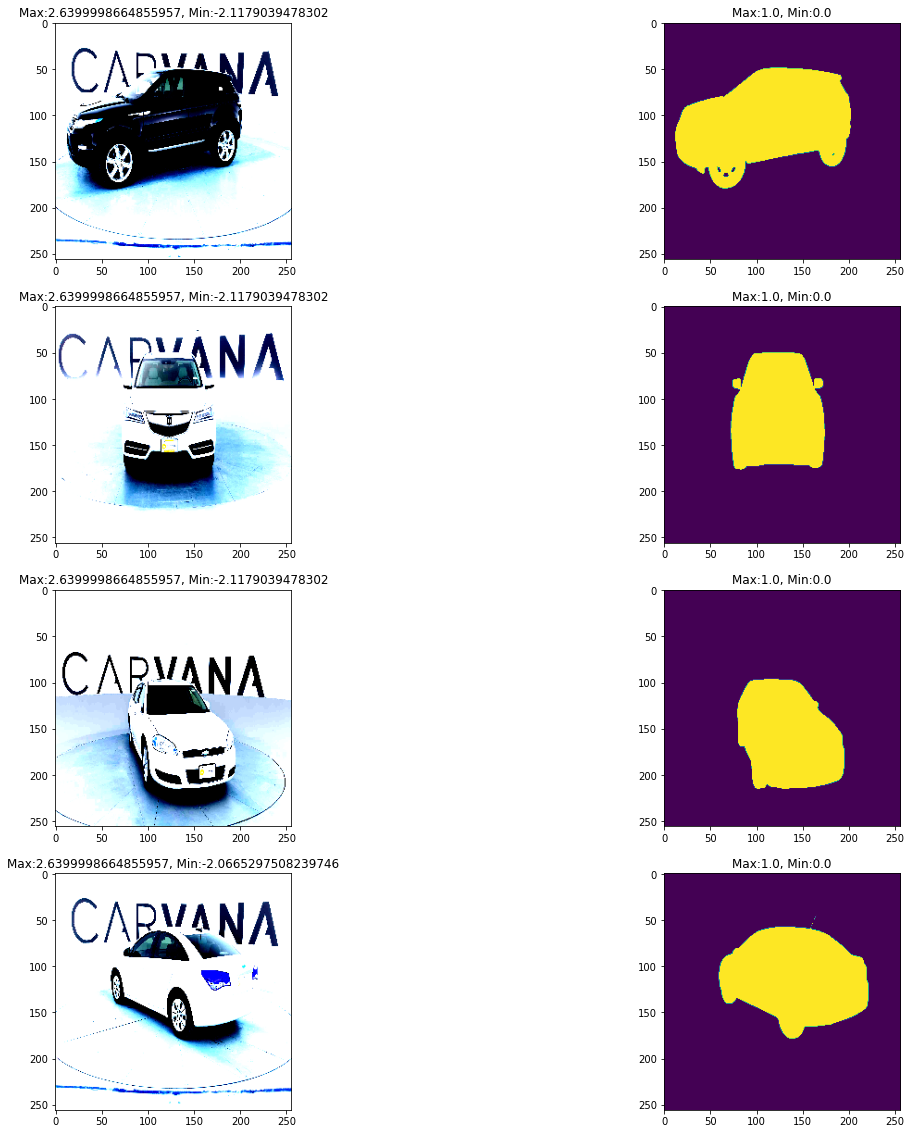

In [ ]:
img, mask = next(iter(train_dataloader))
bs = img.shape[0]
plt.figure(figsize=(20,20))
for i in range(bs):
    plt.subplot(bs,2,(2*i+1))
    plt.title(f"Max:{img[i].max()}, Min:{img[i].min()}")
    plt.imshow(img[i].numpy().transpose(1,2,0))
    plt.subplot(bs,2,(2*i+2))
    plt.title(f"Max:{mask[i].max()}, Min:{mask[i].min()}")
    plt.imshow(mask[i].squeeze().numpy())
    

## 1 batch *val_dataloader*

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


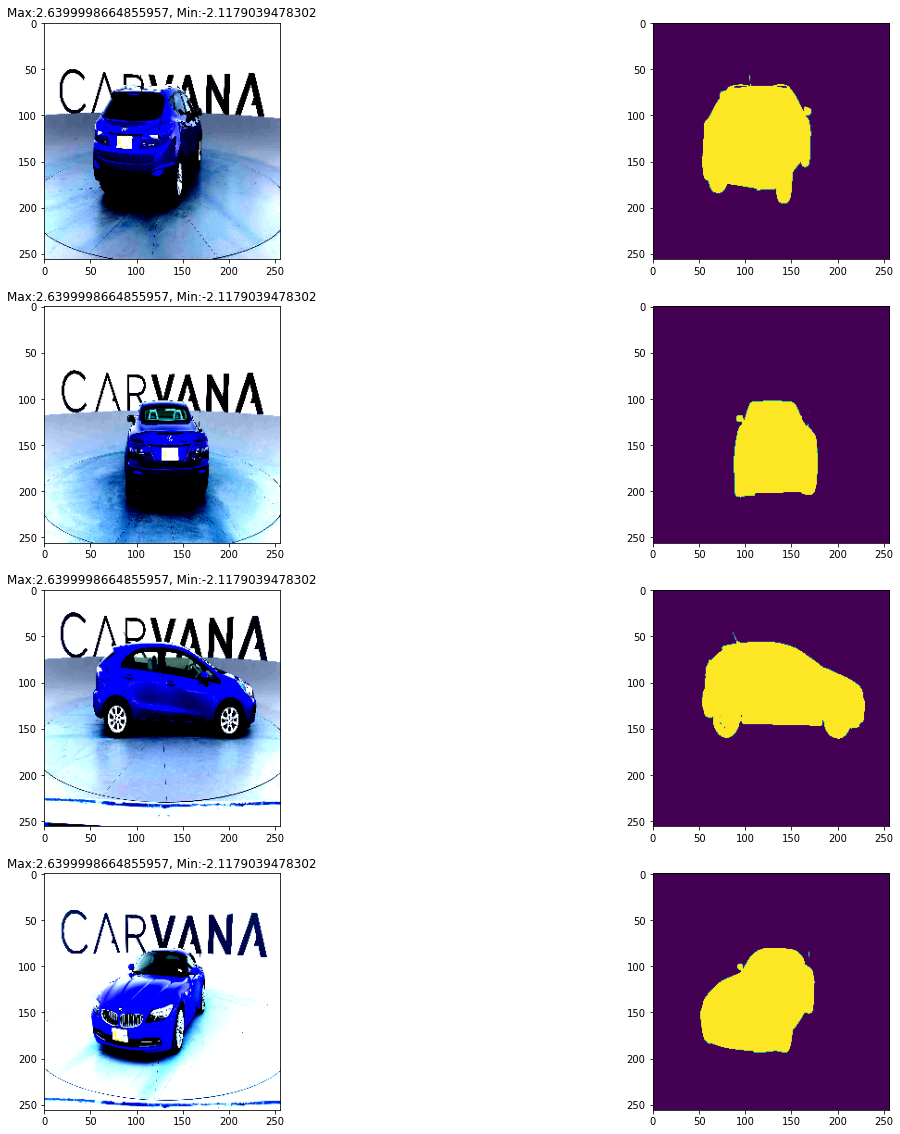

In [ ]:
img, mask = next(iter(val_dataloader))
bs = img.shape[0]
plt.figure(figsize=(20,20))
for i in range(bs):
    plt.subplot(bs,2,(2*i+1))
    plt.title(f"Max:{img[i].max()}, Min:{img[i].min()}")
    plt.imshow(img[i].numpy().transpose(1,2,0))
    plt.subplot(bs,2,(2*i+2))

    plt.imshow(mask[i].squeeze())
    

# Modelo; 1 batch

In [ ]:
model = UNet(n_classes=1,in_ch=3)
model.to(device)  # Se carga el modelo y se envia a la GPU si la hubiera


UNet(
  (conv1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (conv2): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


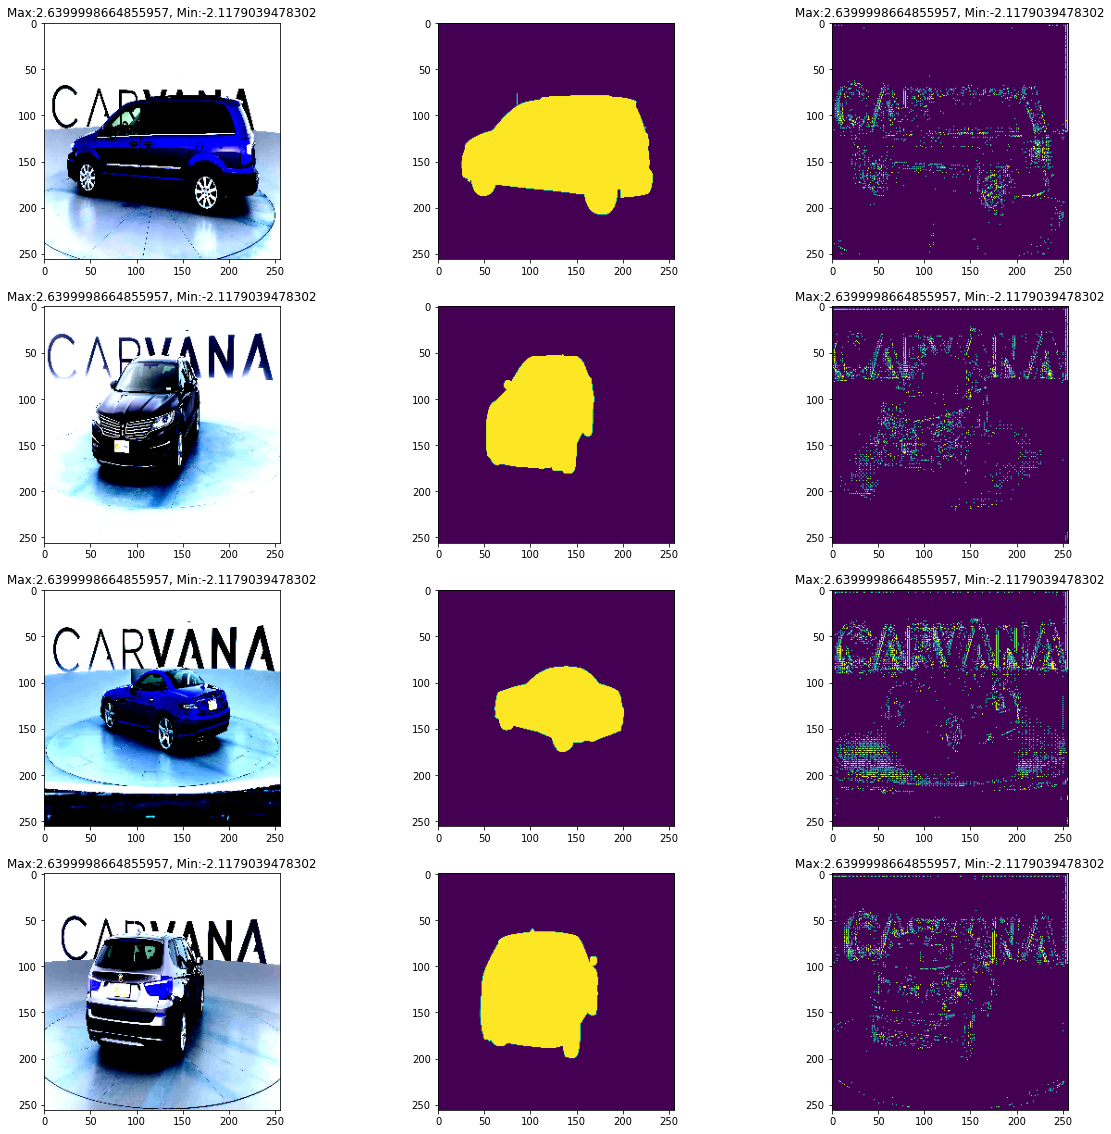

In [ ]:
img, mask = next(iter(train_dataloader)) 
img = img.to(device)
mask = mask.to(device)
pred_mask = model(img) 

bs = img.shape[0]
plt.figure(figsize=(20,20))
for i in range(bs):
    plt.subplot(bs,3,(3*i+1))
    plt.title(f"Max:{img[i].max()}, Min:{img[i].min()}")
    plt.imshow(img[i].cpu().numpy().transpose(1,2,0))
    plt.subplot(bs,3,(3*i+2))
    plt.imshow(mask[i].cpu().squeeze().numpy())
    plt.subplot(bs,3,(3*i+3))
    plt.title(f"Max:{img[i].max()}, Min:{img[i].min()}")
    plt.imshow(pred_mask[i].cpu().squeeze()>0.5)




## Criterion y optimizer



In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [ ]:
def dice_calc(gt,pred) :
    pred = torch.sigmoid(pred)
    pred = ((pred) >= .5).float()
    dice_score = (2 * (pred * gt).sum()) / ((pred + gt).sum() + 1e-8)
    
    return dice_score

In [ ]:
def pixel_acc(gt,pred,bs):
    accsum=0
    for i in range(bs):
        gt_arr = gt[i, :, :, :].clone().detach().cpu().squeeze().numpy()
        pred_arr = pred[i, :, :, :].clone().detach().cpu().squeeze().numpy()
        
        pred_arr = (pred_arr+abs(pred_arr.min()))/((pred_arr+abs(pred_arr.min())).max())
        pred_arr [pred_arr<0.5] = 0
        pred_arr [pred_arr>=0.5] = 1

        same = (gt_arr == pred_arr).sum()
        a, b = pred_arr.shape
        total = a*b
        accsum += same/total
    pixelAccuracy = accsum/bs
    return pixelAccuracy

In [ ]:
def iou_pytorch(gt,pred):

    gt = gt.clone().detach().squeeze(1)
    pred = pred.clone().detach().squeeze(1)
    pred [pred<0.5] = 0
    pred [pred>=0.5] = 1
    intersection = torch.sum(gt * pred)
    eps=1e-7
    union = torch.sum(gt) + torch.sum(pred) - intersection + eps
    iou = ((intersection + eps) / union)

    return iou


In [ ]:
# Train
def train(epoch,epochs,tloader) :
    model.train()
    
    n_train = len(train_dataloader)
    tloader.set_description(f'EPOCH {epoch+1}')
    epoch_loss = 0
    dice_score = 0
    pixel_score = 0 
    iou_score = 0   

      
    
    for images , masks in tloader :
 
        optimizer.zero_grad()
        images = images.to(device, dtype=torch.float32)
        masks  = masks.to(device, dtype=torch.float32)
        mask_pred = model(images)

        loss = criterion(mask_pred,masks)
        epoch_loss += loss.item()      
        loss.backward()
        optimizer.step()
    
        running_DS = dice_calc(masks,mask_pred)
        dice_score += running_DS

        running_PA = pixel_acc(masks,mask_pred,bs)
        pixel_score += running_PA

        running_IOU = iou_pytorch(masks,mask_pred)
        iou_score += running_IOU

        tloader.set_postfix(loss=loss.item(),DS=(running_DS.item()), PA=(running_PA.item()))

    dice_score_epoch = (dice_score/n_train).item()
    pixel_accuracy_score_epoch = (pixel_score/n_train).item()
    iou_score_epoch = (iou_score/n_train).item()

   
    print(f'Train Loss Epoch : {(epoch_loss/n_train)}')
    print(f'Train Dice Score Epoch : {dice_score_epoch}')
    print(f'Train Pixel Accuracy Score Epoch : {pixel_accuracy_score_epoch}\n')
    print(f'Train IoU Epoch : {(iou_score_epoch)}')

    return [(epoch_loss/n_train), dice_score_epoch, pixel_accuracy_score_epoch, iou_score_epoch]

    
def validation(vloader) :
    model.eval()
    vloader.set_description(f'Validation')

    
    n_val = len(val_dataloader)
    epoch_loss = 0
    dice_score = 0
    pixel_score = 0
    iou_score = 0   
    nbatch = 0

    with torch.no_grad():
        for images ,masks in vloader :

            nbatch += 1

            images = images.to(device)
            masks  = masks.to(device)
                
            mask_pred = model(images)
            
            loss = criterion(mask_pred,masks)
            epoch_loss += loss.item()  

            running_DS = dice_calc(masks,mask_pred)
            dice_score += running_DS

            running_PA = pixel_acc(masks,mask_pred,bs)
            pixel_score += running_PA

            running_IOU = iou_pytorch(masks,mask_pred)
            iou_score += running_IOU
            
            vloader.set_postfix(loss=loss.item(),DS=(running_DS.item()), PA=(running_PA.item()))

            if nbatch == 1:
                plt.figure(figsize=(15,15))
                for i in range(bs):
                    plt.subplot(bs,3,(3*i+1))
                    plt.title(f"Input -- Epoch: {epoch+1}")
                    plt.imshow(images[i].cpu().numpy().transpose(1,2,0))
                    plt.subplot(bs,3,(3*i+2))
                    plt.title(f"GT -- Epoch: {epoch+1}")
                    plt.imshow(masks[i].cpu().squeeze().numpy())
                    plt.subplot(bs,3,(3*i+3))
                    plt.title(f"Prediction -- Epoch: {epoch+1}")
                    plt.imshow(mask_pred[i].cpu().squeeze()>0.5)

    dice_score_epoch = (dice_score/n_val).item()
    pixel_accuracy_score_epoch = (pixel_score/n_val).item()
    iou_score_epoch = (iou_score/n_val).item()

    print(f'Validation Loss Epoch : {(epoch_loss/n_val)}')
    print(f'Validation Dice Score Epoch : {dice_score_epoch}')
    print(f'Validation Pixel Accuracy Score Epoch : {pixel_accuracy_score_epoch}')
    print(f'Validation IoU Epoch : {(iou_score_epoch)}')


    return [(epoch_loss/n_val), dice_score_epoch, pixel_accuracy_score_epoch, iou_score_epoch]


1 / 5


EPOCH 1: 100%|██████████| 400/400 [24:41<00:00,  3.70s/batch, DS=0.951, PA=0.908, loss=0.0662]


Train Loss Epoch : 0.21143772903829813
Train Dice Score Epoch : 0.8189989924430847
Train Pixel Accuracy Score Epoch : 0.8784911632537842

Train IoU Epoch : 0.6738909482955933


Validation:   0%|          | 0/100 [00:00<?, ?batch/s, DS=0.948, PA=0.975, loss=0.0585]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Validation: 100%|██████████| 100/100 [05:51<00:00,  3.52s/batch, DS=0.963, PA=0.908, loss=0.062]


Validation Loss Epoch : 0.07218778256326913
Validation Dice Score Epoch : 0.9466109275817871
Validation Pixel Accuracy Score Epoch : 0.9376374053955078
Validation IoU Epoch : 0.9017340540885925
2 / 5


EPOCH 2: 100%|██████████| 400/400 [01:58<00:00,  3.38batch/s, DS=0.966, PA=0.945, loss=0.0423]


Train Loss Epoch : 0.05451528009958565
Train Dice Score Epoch : 0.9561447501182556
Train Pixel Accuracy Score Epoch : 0.9432551860809326

Train IoU Epoch : 0.9104454517364502


Validation:   0%|          | 0/100 [00:00<?, ?batch/s, DS=0.974, PA=0.984, loss=0.0281]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Validation: 100%|██████████| 100/100 [00:23<00:00,  4.20batch/s, DS=0.977, PA=0.955, loss=0.0347]


Validation Loss Epoch : 0.039878032095730306
Validation Dice Score Epoch : 0.9685975313186646
Validation Pixel Accuracy Score Epoch : 0.9562552261352539
Validation IoU Epoch : 0.9384387135505676
3 / 5


EPOCH 3: 100%|██████████| 400/400 [01:58<00:00,  3.39batch/s, DS=0.974, PA=0.968, loss=0.0296]


Train Loss Epoch : 0.03939741749316454
Train Dice Score Epoch : 0.9672215580940247
Train Pixel Accuracy Score Epoch : 0.9580355358123779

Train IoU Epoch : 0.9333227276802063


Validation:   0%|          | 0/100 [00:00<?, ?batch/s, DS=0.979, PA=0.987, loss=0.0219]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Validation: 100%|██████████| 100/100 [00:24<00:00,  4.10batch/s, DS=0.975, PA=0.956, loss=0.034]


Validation Loss Epoch : 0.034967428781092165
Validation Dice Score Epoch : 0.9704666137695312
Validation Pixel Accuracy Score Epoch : 0.9634591293334961
Validation IoU Epoch : 0.9358829855918884
4 / 5


EPOCH 4: 100%|██████████| 400/400 [01:58<00:00,  3.37batch/s, DS=0.976, PA=0.977, loss=0.0263]


Train Loss Epoch : 0.03317001159768552
Train Dice Score Epoch : 0.9718632102012634
Train Pixel Accuracy Score Epoch : 0.9643208026885987

Train IoU Epoch : 0.9431515336036682


Validation:   0%|          | 0/100 [00:00<?, ?batch/s, DS=0.979, PA=0.989, loss=0.0197]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Validation: 100%|██████████| 100/100 [00:24<00:00,  4.07batch/s, DS=0.981, PA=0.97, loss=0.0243]


Validation Loss Epoch : 0.028187213465571404
Validation Dice Score Epoch : 0.976176917552948
Validation Pixel Accuracy Score Epoch : 0.9696208572387696
Validation IoU Epoch : 0.9516874551773071
5 / 5


EPOCH 5: 100%|██████████| 400/400 [01:59<00:00,  3.35batch/s, DS=0.978, PA=0.981, loss=0.0247]


Train Loss Epoch : 0.028408298902213573
Train Dice Score Epoch : 0.9758018851280212
Train Pixel Accuracy Score Epoch : 0.9702206039428711

Train IoU Epoch : 0.9508834481239319


Validation:   0%|          | 0/100 [00:00<?, ?batch/s, DS=0.982, PA=0.989, loss=0.0176]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Validation: 100%|██████████| 100/100 [00:24<00:00,  4.06batch/s, DS=0.981, PA=0.969, loss=0.0243]


Validation Loss Epoch : 0.02624740468338132
Validation Dice Score Epoch : 0.9777917265892029
Validation Pixel Accuracy Score Epoch : 0.9711089324951172
Validation IoU Epoch : 0.9561920762062073


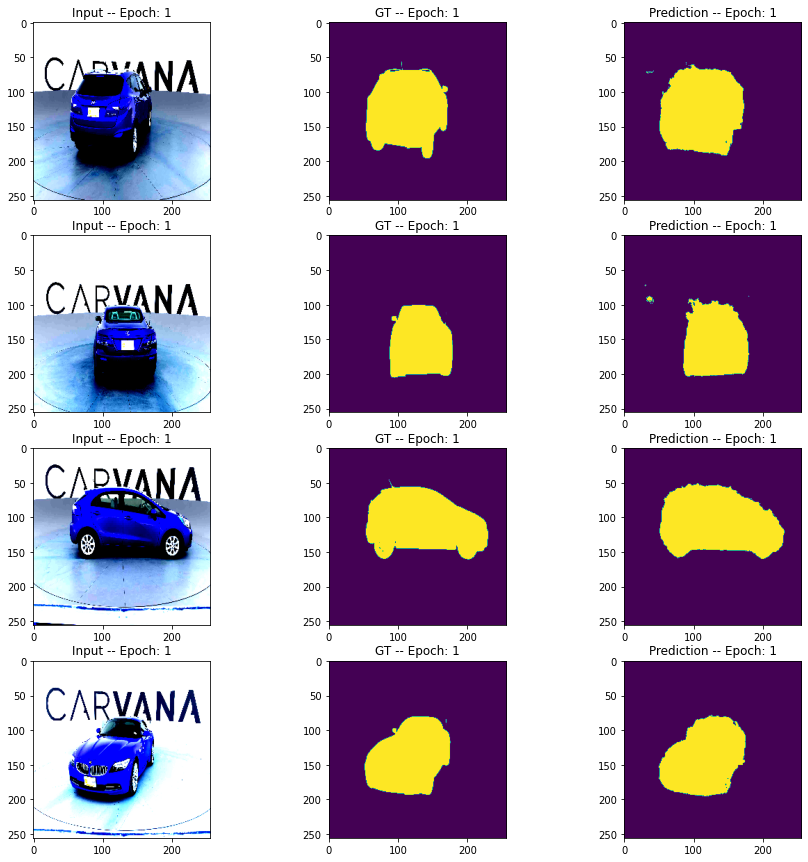

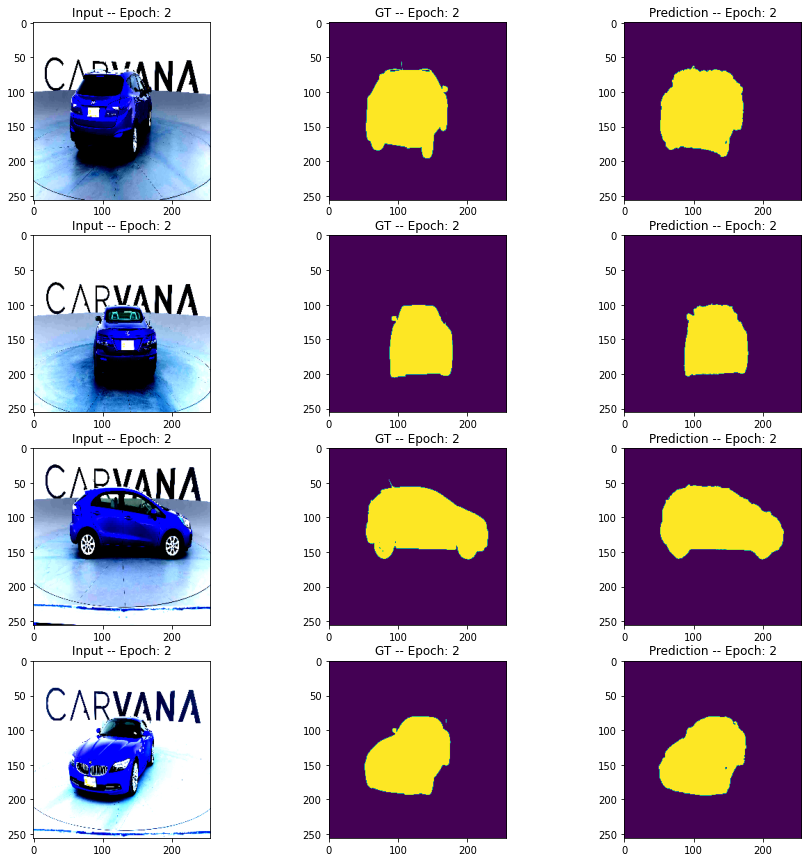

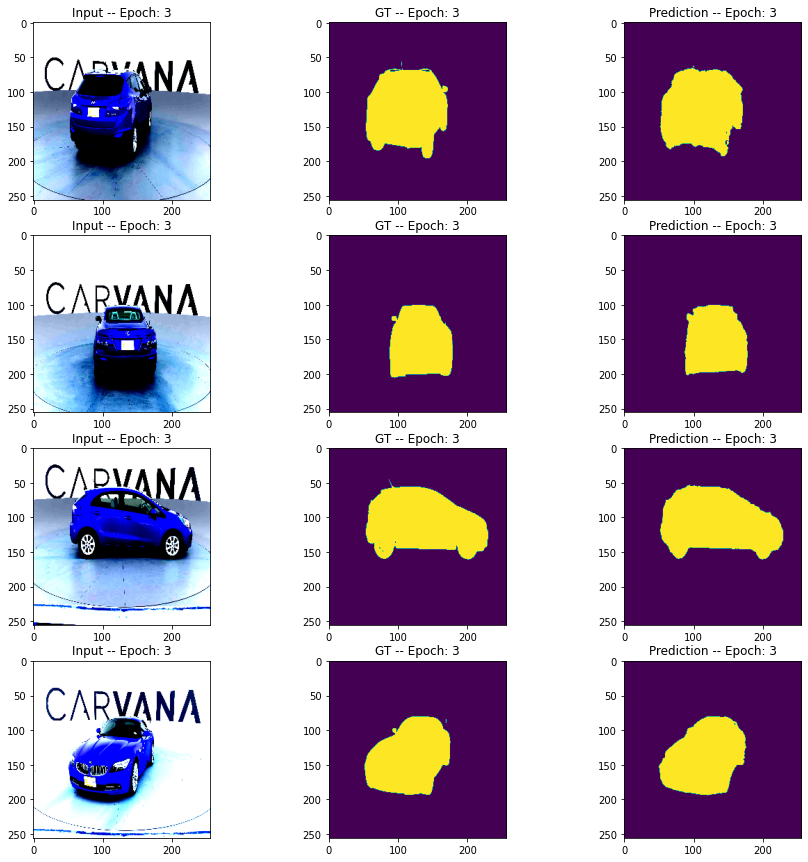

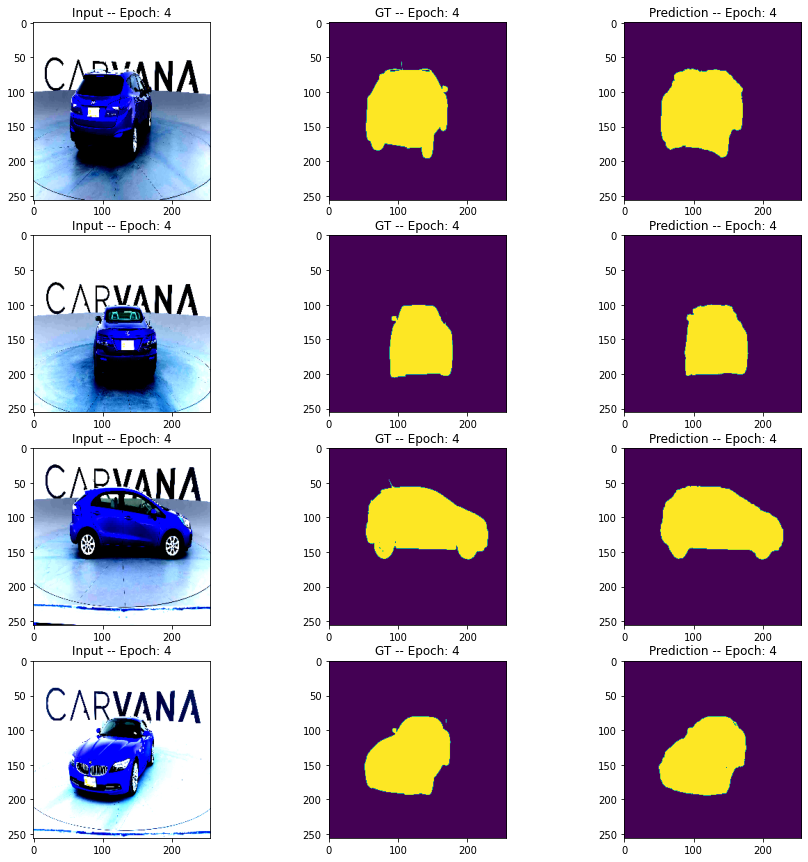

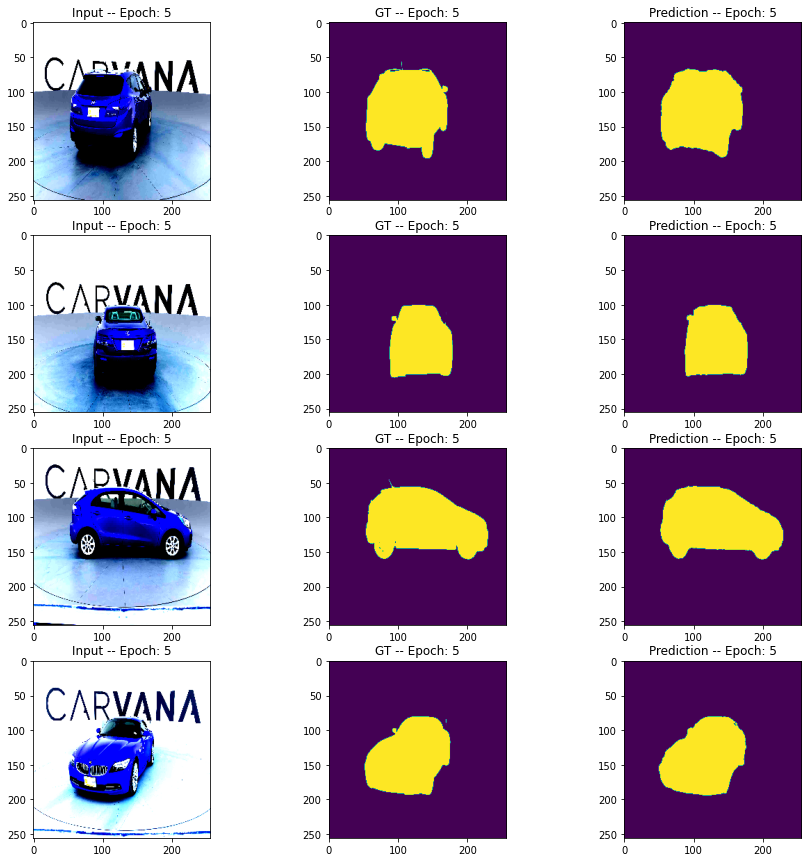

In [ ]:
epochs = 5

train_loss = []
train_dice_score = []
train_pixel_score = []
train_iou_score = []

val_loss = []
val_dice_score = []
val_pixel_score = []
val_iou_score = []

for epoch in range(epochs) :
    print(epoch+1,'/',epochs)
    with tqdm(train_dataloader,unit='batch') as tloader : 
        train_scores = train(epoch,epochs,tloader)
        train_loss.append(train_scores[0])
        train_dice_score.append(train_scores[1])
        train_pixel_score.append(train_scores[2])
        train_iou_score.append(train_scores[3])
    
    with tqdm(val_dataloader,unit='batch') as vloader:
        val_scores = validation(vloader)
        val_loss.append(val_scores[0])
        val_dice_score.append(val_scores[1])
        val_pixel_score.append(val_scores[2])
        val_iou_score.append(val_scores[3])

        if epoch == 0:
            PATH = '/content/drive/MyDrive/Colab_Notebooks/carvana/carvana.pth'
            torch.save(model.state_dict(), PATH)
        else:
          if val_pixel_score[epoch]>= val_pixel_score[epoch-1]:
              PATH = '/content/drive/MyDrive/Colab_Notebooks/carvana/carvana.pth'
              torch.save(model.state_dict(), PATH)

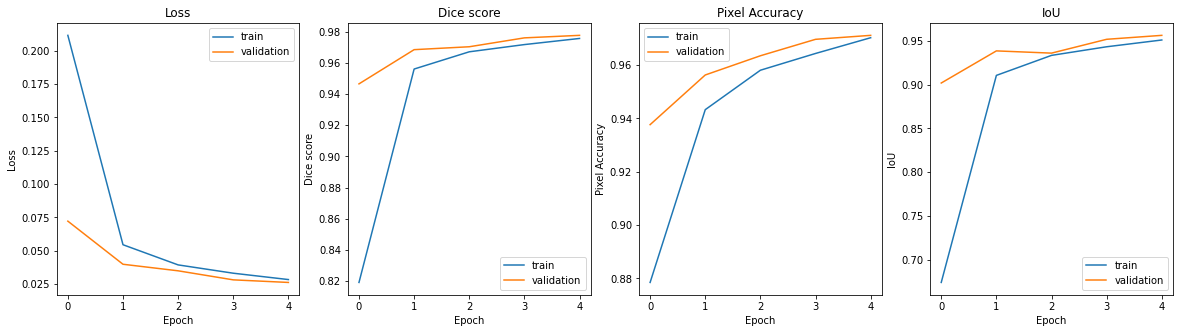

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.title(f"Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='validation')
plt.legend()


plt.subplot(1,4,2)
plt.title(f"Dice score")
plt.xlabel('Epoch')
plt.ylabel('Dice score')
plt.plot(train_dice_score, label='train')
plt.plot(val_dice_score, label='validation')
plt.legend()


plt.subplot(1,4,3)
plt.title(f"Pixel Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Pixel Accuracy')
plt.plot(train_pixel_score, label='train')
plt.plot(val_pixel_score, label='validation')
plt.legend()


plt.subplot(1,4,4)
plt.title(f"IoU")
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.plot(train_iou_score, label='train')
plt.plot(val_iou_score, label='validation')
plt.legend()

